In [87]:
import numpy as np
import random
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from models.vae import VAE 
from models.controller import Controller
from torchsummary import summary

input_size = 32 + 13
output_size = 13

model = Controller(input_size, output_size).cuda()
summary(model, (1, input_size))

In [ ]:
pc0 = 0.0910
pc1 = 0.1467
b = 0.6
c = 0.3

pc = ((pc0*pc1)**b) * (((pc1-pc0)/pc1)**c) 
ic = 0.0697

print(f'{100.0 + ic/pc}, {pc}')

In [72]:
dirname = '20200820_003939'
name = 'WIDE_VISION'

results_folder = 'results'
optimizer = 'cma'
num_rollouts = 1
popsize = 32

filename = os.path.join(results_folder, dirname, 'fitness.txt')
filename_ind = os.path.join(results_folder, dirname, 'ind_fitness.txt')

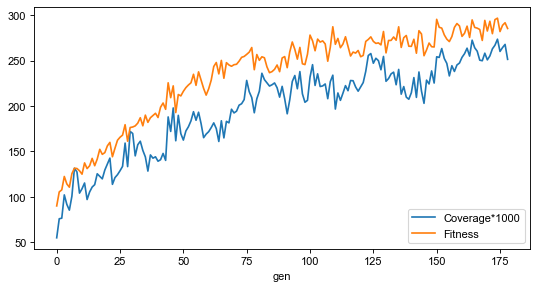

In [76]:
with open(filename_ind, 'r') as f:
  data_ind = np.loadtxt(f, delimiter='/', skiprows=1)

df = pd.DataFrame(data=data_ind, columns=["gen", "id", "fitness", "coverage", "coverage_reward", "IC", "PC", "PCt0", "PCt1"])

df["coverage"] *= 1000
df["IC"] *= 300
df["PC"] = (df["PCt1"] - df["PCt0"]) * 10000

# grouped_df = df.groupby('gen').agg({
#     "coverage": [np.mean], 
#     "fitness": [np.mean],
#     "IC": [np.mean],
#     "PC": [np.mean]})

grouped_df = df.groupby('gen').agg({
    "coverage": [np.mean], 
    "fitness": [np.mean]
})

fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()

grouped_df.plot(kind='line', ax=ax)
ax.legend(["Coverage*1000", "Fitness"], loc=4);


plt.show()

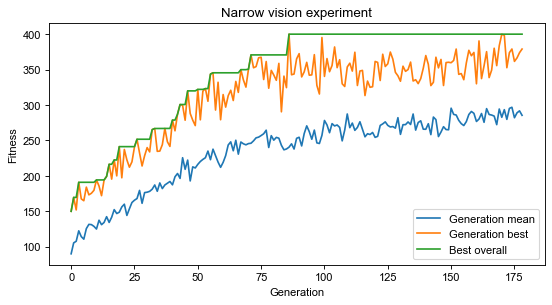

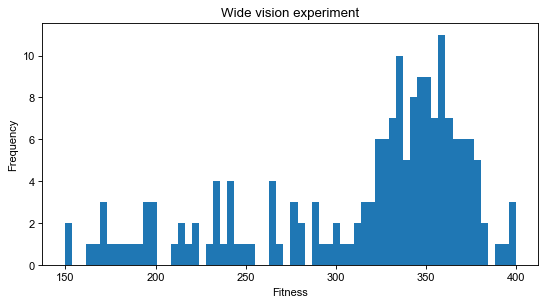

In [77]:
with open(filename, 'r') as f:
  data = np.loadtxt(f, delimiter='/', skiprows=1)

plt.rcParams["font.family"] = "Arial"
fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

line_mean, = plt.plot(data[:, 0], data[:, 1])
line_best_gen, = plt.plot(data[:, 0], data[:, 2])
line_best_overall, = plt.plot(data[:, 0], data[:, 3])
plt.legend([line_mean, line_best_gen, line_best_overall], ['Generation mean', 'Generation best', 'Best overall'], loc=4)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Narrow vision experiment')
plt.savefig(os.path.join(results_folder, dirname, name) + ".svg")

fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
plt.title('Wide vision experiment')
#plt.savefig(os.path.join(results_folder, dirname, name) + ".svg")

plt.hist(data[:, 2], density=False, bins=64) 
plt.ylabel('Frequency')
plt.xlabel('Fitness');

plt.show()

In [110]:
impath = "results/final/20200817_222809_NARROW_VISION_0/artifacts"
imlist = os.listdir(impath)
list_im = [Image.open(os.path.join(impath, random.choice(imlist))) for i in range(4)]

imgs_arr = np.vstack(list_im)
imgs_comb = Image.fromarray(imgs_arr)
#imgs_comb.save('1.png')   

imgs_comb.show()